In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import re

In [2]:
smile_on = pd.read_csv('../data/SmileOn11.28.2020.csv', sep = ',', encoding='gbk', skiprows = 2)
data_dict = pd.read_excel('../data/Data_Dictionary.xlsx')
bill = pd.read_csv('../data/Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_PUF_CY2017 (1).csv')
prov_out = pd.read_csv('../data/Provider_Outpatient_Hospital_Charge_Data_by_APC__CY2017.csv')
city_info = pd.read_csv('../data/500_Cities__Local_Data_for_Better_Health__2019_release.csv')
apc = pd.read_excel('../data/2020_October_Web_Addendum_B.10212020.xlsx', skiprows = 2)
hcpcs = pd.read_excel('../data/2020_October_Web_Addendum_A.10212020.xlsx', skiprows = 1)

C:\Users\heath\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (32,36,53,59,88,89,127,141,144,156,157,158,159) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## CDC Tooth Loss Data

In [3]:
city_info_tn = city_info[city_info['StateAbbr'] == 'TN']
city_info_tn_teeth_loss = city_info_tn[(city_info_tn['Measure'] == 'All teeth lost among adults aged >=65 Years') & (city_info_tn['GeographicLevel'] == 'City') & (city_info_tn['DataValueTypeID'] == 'AgeAdjPrv')]

In [4]:
tooth_loss_chart = city_info_tn_teeth_loss.iloc[:, 0:18].sort_values(by='CityName')
tooth_loss_chart = tooth_loss_chart.sort_values(by='Data_Value')

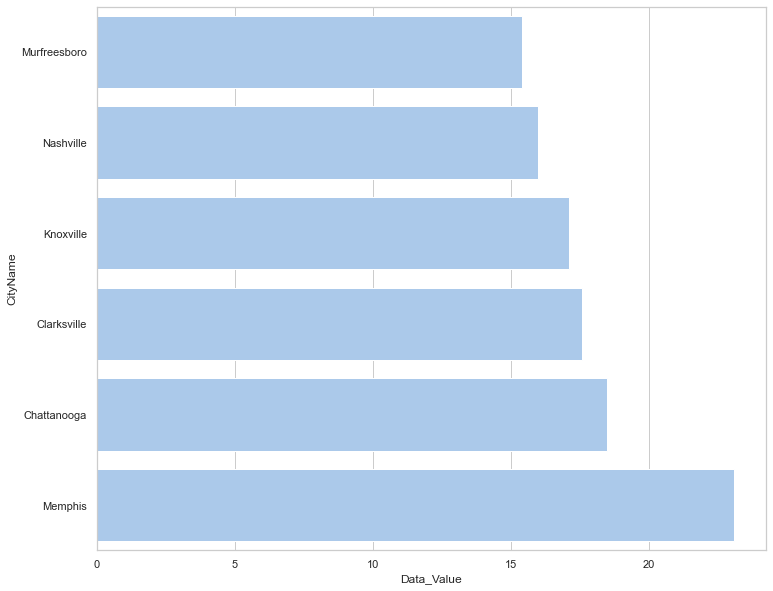

In [5]:
#Chart of major cities in TN - percentage of adults over 65 with all teeth loss
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(12, 10))
sns.set_color_codes("pastel")
sns.barplot(y="CityName", x="Data_Value", data=tooth_loss_chart,
            label="Total", color="b")

## Smile On Data

In [6]:
smile_on.shape

(40032, 184)

In [7]:
so_1 = smile_on[['CallReportNum', 'ReportVersion', 'CallerNum', 'CityName', 'CountyName', 'PostalCode', 'EnteredOn', 'Birth Year', 'SMILE ON 60+ Screening - Last Screening Date', 'SMILE ON 60+ Oral Care Encounter - What care was provided to the enrollee? (Select all that apply)', 'SMILE ON 60+ Site Information - Enroller ID', 'SMILE ON 60+ Site Information - Enroller Location', 'SMILE ON 60+ Treatment Plan - Is the treatment plan completed?', 'SMILE ON 60+ Treatment Plan - Was a treatment plan developed?', 'SMILE ON 60+ Treatment Plan - Was the enrollee able to be restored to function (can chew) and "social six" esthetics (top front six teeth are present and disease free)', 'SMILE ON 60+ Verification of Eligibility - Transportation Arranged', 'SMILE ON 60+ Verification of Eligibility - Verification of Eligibility']]

In [8]:
so_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40032 entries, 0 to 40031
Data columns (total 17 columns):
 #   Column                                                                                                                                                                   Non-Null Count  Dtype  
---  ------                                                                                                                                                                   --------------  -----  
 0   CallReportNum                                                                                                                                                            40032 non-null  int64  
 1   ReportVersion                                                                                                                                                            40032 non-null  object 
 2   CallerNum                                                                                     

In [9]:
so_1 = so_1.sort_values(by='CallerNum')

In [10]:
so_1 = so_1[(so_1['CallerNum'] != -1) & (so_1['CallerNum'] != -2)]

In [11]:
so_1.columns=['CallReportNum', 'ReportVersion', 'CallerNum', 'CityName', 'CountyName',
       'PostalCode', 'EnteredOn', 'Birth Year',
       'Screening - Last Screening Date',
       'Oral Care Encounter - What care was provided to the enrollee?',
       'Site Information - Enroller ID',
       'Site Information - Enroller Location',
       'Treatment Plan - Is the treatment plan completed?',
       'Treatment Plan - Was a treatment plan developed?',
       'Treatment Plan - Was the enrollee able to be restored to function',
       'Verification of Eligibility Transportation Arranged',
       'Verification of Eligibility']
so_1.columns

Index(['CallReportNum', 'ReportVersion', 'CallerNum', 'CityName', 'CountyName',
       'PostalCode', 'EnteredOn', 'Birth Year',
       'Screening - Last Screening Date',
       'Oral Care Encounter - What care was provided to the enrollee?',
       'Site Information - Enroller ID',
       'Site Information - Enroller Location',
       'Treatment Plan - Is the treatment plan completed?',
       'Treatment Plan - Was a treatment plan developed?',
       'Treatment Plan - Was the enrollee able to be restored to function',
       'Verification of Eligibility Transportation Arranged',
       'Verification of Eligibility'],
      dtype='object')

In [12]:
patients_restored = so_1[so_1['Treatment Plan - Was the enrollee able to be restored to function'].isin(['Yes', 'No'])]

In [13]:
patients_restored = patients_restored.sort_values(by = 'EnteredOn')
patients_restored = patients_restored.drop_duplicates(['CallerNum'], keep='last')
patients_restored.shape

(4575, 17)

In [14]:
patients_restored['Treatment Plan - Was the enrollee able to be restored to function'].value_counts()

Yes    2488
No     2087
Name: Treatment Plan - Was the enrollee able to be restored to function, dtype: int64

In [15]:
patients_restored_yes = patients_restored[patients_restored['Treatment Plan - Was the enrollee able to be restored to function'] == 'Yes']
patients_restored_no = patients_restored[patients_restored['Treatment Plan - Was the enrollee able to be restored to function'] == 'No']

In [16]:
yes = patients_restored_yes['Site Information - Enroller ID'].value_counts().to_frame().reset_index()
no = patients_restored_no['Site Information - Enroller ID'].value_counts().to_frame().reset_index()

In [17]:
combo = pd.merge(yes, no, on = 'index')

In [18]:
combo['total'] = combo['Site Information - Enroller ID_x'] + combo['Site Information - Enroller ID_y']

In [19]:
combo['percentage'] = (combo['Site Information - Enroller ID_x']/combo['total'])*100

In [20]:
combo.columns = ['location', 'restored_yes', 'restored_no', 'total', 'percentage' ]

In [21]:
combo = combo.head()

<BarContainer object of 5 artists>

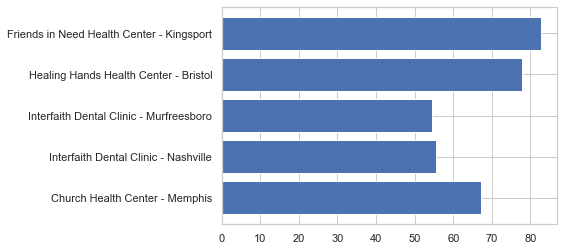

In [22]:
plt.barh('location', 'percentage', data = combo)

In [23]:
print(re.sub(' - ', '\n', 'Church Health Center - Memphis'))

Church Health Center
Memphis


In [24]:
list = []
for index, row in combo.iterrows():
    list.append(re.sub(' - ', '\n', row['location']))

In [25]:
list

['Church Health Center\nMemphis',
 'Interfaith Dental Clinic\nNashville',
 'Interfaith Dental Clinic\nMurfreesboro',
 'Healing Hands Health Center\nBristol',
 'Friends in Need Health Center\nKingsport']

In [26]:
combo['new'] = list

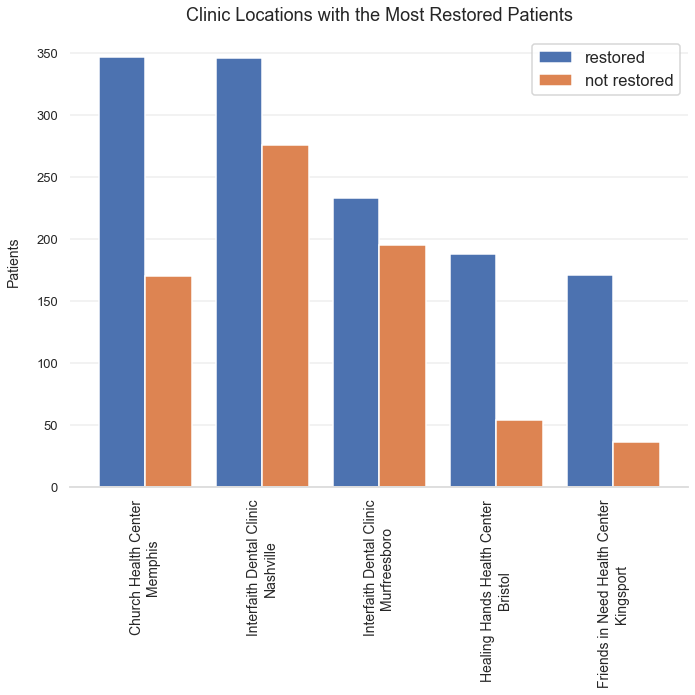

In [27]:
# Use Seaborn's context settings to make fonts larger.
sns.set_context('talk')

# Create a grouped bar chart, with location as the x-axis
# and number of patients as the variable we're grouping on so there
# are two bars per location.
fig, ax = plt.subplots(figsize=((10, 10)))

# Our x-axis. We basically just want a list
# of numbers from zero with a value for each
# of our locations.
x = np.arange(len(combo['new'].unique()))

# Define bar width. We need this to offset the second bar.
bar_width = 0.4

b1 = ax.bar(x, combo['restored_yes'],
            width=bar_width, label='restored')
# Same thing, but offset the x.
b2 = ax.bar(x + bar_width, combo['restored_no'],
            width=bar_width, label='not restored')

# Fix the x-axes.
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(combo['new'].unique())
plt.xticks(rotation=90, fontsize = 14)

# Add legend.
ax.legend()

# Axis styling.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add axis and chart labels.
#ax.set_xlabel('Location', labelpad=15, fontsize=12)
ax.set_ylabel('Patients', labelpad=15, fontsize=14)
plt.yticks(fontsize=13)
ax.set_title('Clinic Locations with the Most Restored Patients', pad=15)

fig.tight_layout()

## Unique patients 

In [28]:
patients = so_1.drop_duplicates(['CallerNum'], keep='first')

In [29]:
patients.head()

,CallReportNum,ReportVersion,CallerNum,CityName,CountyName,PostalCode,EnteredOn,Birth Year,Screening - Last Screening Date,Oral Care Encounter - What care was provided to the enrollee?,Site Information - Enroller ID,Site Information - Enroller Location,Treatment Plan - Is the treatment plan completed?,Treatment Plan - Was a treatment plan developed?,Treatment Plan - Was the enrollee able to be restored to function,Verification of Eligibility Transportation Arranged,Verification of Eligibility
937,80389848,SMILE ON 60+ Clinical,2061444,NaN,NaN,NaN,10/30/2020 11:39,1900,NaN,NaN,Church Health Center - Memphis,NaN,NaN,NaN,NaN,NaN,NaN
40021,53601932,SMILE ON 60+ Clinical,2307186,Nashville,Davidson,37201.0,6/8/2018 8:21,4670,NaN,150 - Comprehensive Oral Evaluation -new or es...,Interfaith Dental Clinic - Murfreesboro,Senior Center,NaN,NaN,NaN,Yes,Yes
31972,61675197,SMILE ON 60+ Clinical,2384106,Murfreesboro,Rutherford,37130.0,3/29/2019 10:56,1944,8/1/2018,330 - Panoramic film - 5; 7210 - Extraction su...,Interfaith Dental Clinic - Murfreesboro,NaN,NaN,NaN,NaN,NaN,NaN
38122,57056425,SMILE ON 60+ Clinical,2384744,Nashville,Davidson,37211.0,10/11/2018 19:40,1954,8/1/2018,1330 - Oral Hygiene Instructions - ; 1206 - ap...,Interfaith Dental Clinic - Nashville,NaN,NaN,Yes,NaN,NaN,NaN
37124,57788255,SMILE ON 60+ Clinical,2384833,Hartsville,Trousdale,37074.0,11/8/2018 10:18,1942,8/7/2018,No Code - Denture step Mandibular: may be used...,Interfaith Dental Clinic - Nashville,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
patients_city = patients.groupby('CityName').size()

In [32]:
patients_city

CityName
1450830        1
Adamsville     1
Afton          3
Alamo          1
Alcoa          8
              ..
Williston      1
Winchester    16
Woodbine       7
Woodbury      40
Woodlawn       7
Length: 387, dtype: int64